In [1]:
!pip install split-folders

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import splitfolders
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,Conv2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0,DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix

2025-05-19 16:22:28.958350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747671749.145114      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747671749.207234      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
splitfolders.ratio('/kaggle/input/asl-dataset/asl_dataset',output='/kaggle/working/', seed=1333, ratio=(0.8,0.1,0.1))#80% train, 10% val, 10% test

Copying files: 2515 files [00:17, 144.09 files/s]


In [4]:
#deleting the empty frolder "asl_dataset" created while copying files
import shutil
shutil.rmtree("/kaggle/working/train/asl_dataset")
shutil.rmtree("/kaggle/working/val/asl_dataset")
shutil.rmtree("/kaggle/working/test/asl_dataset")

In [5]:
img_width, img_height = 224, 224
batchsize = 32


train_datagen = ImageDataGenerator(rescale=1.0 / 255)


test_val_datagen = ImageDataGenerator(rescale= 1.0 / 255)


train = train_datagen.flow_from_directory(
    directory='/kaggle/working/train/',
    target_size=(img_width, img_height),
    batch_size=batchsize,
    class_mode='categorical',
)

validation = test_val_datagen.flow_from_directory(
    directory='/kaggle/working/val',
    target_size=(img_width, img_height),
    batch_size=batchsize,
    class_mode='categorical',
)

test = test_val_datagen.flow_from_directory(
    directory='/kaggle/working/test',
    target_size=(img_width, img_height),
    batch_size=batchsize,
    class_mode='categorical',
    shuffle=False
)


Found 2012 images belonging to 36 classes.
Found 251 images belonging to 36 classes.
Found 252 images belonging to 36 classes.


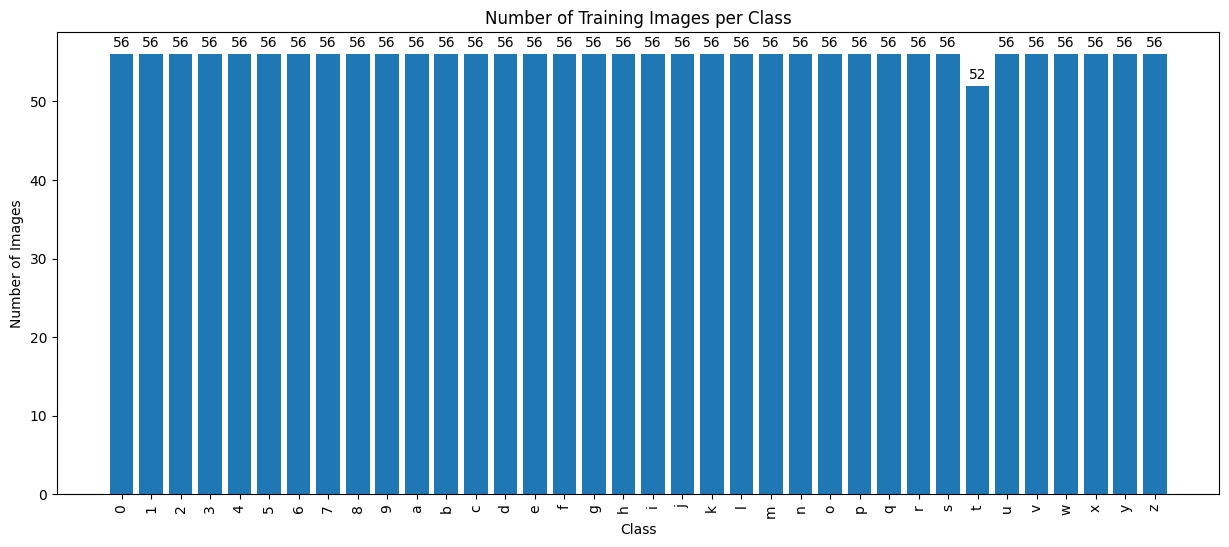

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

class_indices = train.class_indices
labels = train.classes
class_counts = Counter(labels)

# Convert class indices to class names (sorted by index)
class_names = [None] * len(class_indices)
for class_name, idx in class_indices.items():
    class_names[idx] = class_name

# Get counts ordered by class index
counts_ordered = [class_counts[i] for i in range(len(class_names))]

plt.figure(figsize=(15,6))
bars = plt.bar(class_names, counts_ordered)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Training Images per Class')

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + .5,                         
        str(int(height)),                  
        ha='center',                       
        va='bottom'                        
    )

plt.show()


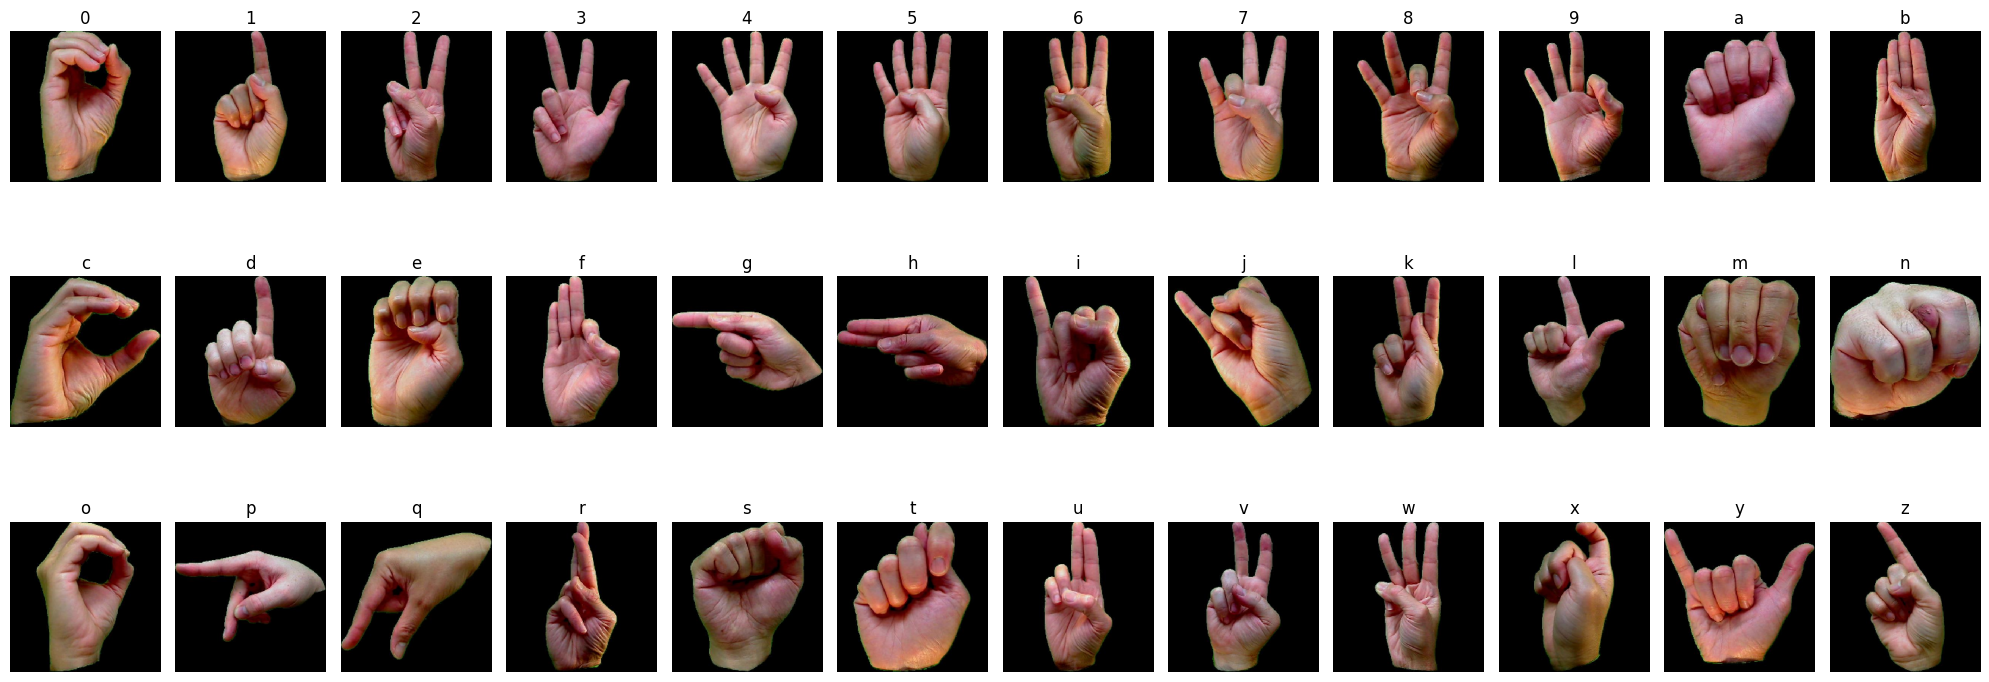

In [7]:
# Get class names in order of their index
class_names = [None] * len(train.class_indices)
for name, idx in train.class_indices.items():
    class_names[idx] = name

# Create a dictionary to keep track of which classes we've already shown
shown_classes = {}

plt.figure(figsize=(20, 8))

# Iterate over batches until we have one image per class
for images, labels in train:
    class_indices_in_batch = np.argmax(labels, axis=1)
    
    for i, class_idx in enumerate(class_indices_in_batch):
        if class_idx not in shown_classes:
            shown_classes[class_idx] = images[i]
            
            # Stop if we got all classes
            if len(shown_classes) == len(class_names):
                break
    if len(shown_classes) == len(class_names):
        break

# Plot one image per class
for i, class_idx in enumerate(sorted(shown_classes.keys())):
    plt.subplot(3, 12, i+1)  #(36 classes = 3 rows x 12 cols)
    plt.imshow(shown_classes[class_idx])
    plt.title(class_names[class_idx])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
num_classes = 36
input_shape = (224, 224, 3)

cnn = Sequential()

# Input Layer
# Block 1
cnn.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape))
cnn.add(Conv2D(32, 3, activation='relu', padding='same'))
# cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(padding='same'))
cnn.add(Dropout(0.2))

# Block 2
cnn.add(Conv2D(64, 3, activation='relu', padding='same'))
cnn.add(Conv2D(64, 3, activation='relu', padding='same'))
# cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(padding='same'))
cnn.add(Dropout(0.3))

# Block 3
cnn.add(Conv2D(128, 3, activation='relu', padding='same'))
cnn.add(Conv2D(128, 3, activation='relu', padding='same'))
# cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(padding='same'))
cnn.add(Dropout(0.4))

# Fully Connected Layers
cnn.add(Flatten())
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.3))

# Output Layer
cnn.add(Dense(36, activation='softmax'))


# Compile Model
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747671782.679063      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,738,052 (197.37 MB)

 Trainable params: 51,738,052 (197.37 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
train_layers_Den = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
Den = Sequential()
Den.add(train_layers_Den)
Den.add(GlobalAveragePooling2D())
Den.add(Dense(1024, activation='relu'))
Den.add(Dense(512, activation='relu'))
Den.add(Dense(36, activation='softmax'))

Den.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Den.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 36)                  │          18,468 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,630,372 (32.92 MB)

 Trainable params: 8,546,724 (32.60 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [10]:
train_layers_EffNet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
EffNet = Sequential()
EffNet.add(train_layers_EffNet)
EffNet.add(GlobalAveragePooling2D())
EffNet.add(Dense(1024, activation='relu'))
EffNet.add(Dense(512, activation='relu'))
EffNet.add(Dense(36, activation='softmax'))

EffNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EffNet.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 36)                  │          18,468 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,904,583 (22.52 MB)

 Trainable params: 5,862,560 (22.36 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [11]:
early_stop_cnn = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True, verbose=1)
reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

early_stop_den = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True, verbose=1)
reduce_lr_den = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

early_stop_eff = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True, verbose=1)
reduce_lr_eff = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

cnn_history = cnn.fit(
    train,
    validation_data=validation,
    epochs=20,
    callbacks=[early_stop_cnn, reduce_lr_cnn]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747671792.590270      89 service.cc:148] XLA service 0x7c4c70004f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747671792.591189      89 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747671793.071641      89 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.0156 - loss: 3.7327      

I0000 00:00:1747671803.356826      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 303ms/step - accuracy: 0.1489 - loss: 3.1474 - val_accuracy: 0.8287 - val_loss: 0.5550 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.7877 - loss: 0.6940 - val_accuracy: 0.8845 - val_loss: 0.3091 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.8976 - loss: 0.3254 - val_accuracy: 0.9163 - val_loss: 0.2188 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9305 - loss: 0.1922 - val_accuracy: 0.9602 - val_loss: 0.1504 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9514 - loss: 0.1432 - val_accuracy: 0.9641 - val_loss: 0.0960 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9694 - loss: 0.0933 - val_accuracy: 0.9681 - val_loss: 0.1546 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9662 - loss: 0.0918
Epoch 7: ReduceLRO

In [12]:
Den_history = Den.fit(
    train,
    validation_data=validation,
    epochs=20,
    callbacks=[early_stop_den, reduce_lr_den]
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.4922 - loss: 1.9250 - val_accuracy: 0.1713 - val_loss: 9.2223 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.8753 - loss: 0.3413 - val_accuracy: 0.4701 - val_loss: 3.6583 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9387 - loss: 0.1797 - val_accuracy: 0.7291 - val_loss: 1.7095 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9257 - loss: 0.1904 - val_accuracy: 0.6614 - val_loss: 1.4078 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.9360 - loss: 0.2051 - val_accuracy: 0.7450 - val_loss: 1.8869 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9604 - loss: 0.1270 - val_accuracy: 0.9163 - val_loss: 0.3135 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.9672 - loss: 0.09

In [13]:
EffNet_history = EffNet.fit(
    train,
    validation_data=validation,
    epochs=20,
    callbacks=[early_stop_eff, reduce_lr_eff]
)

Epoch 1/20


E0000 00:00:1747672395.477624      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747672395.663377      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747672396.131473      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747672396.337422      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747672396.698073      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

15/63 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.2107 - loss: 3.0646

E0000 00:00:1747672428.868476      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747672429.054169      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747672429.513549      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747672429.722025      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747672430.081667      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

63/63 ━━━━━━━━━━━━━━━━━━━━ 137s 828ms/step - accuracy: 0.5000 - loss: 1.8673 - val_accuracy: 0.0279 - val_loss: 4.6788 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.8987 - loss: 0.2628 - val_accuracy: 0.0279 - val_loss: 6.2088 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.9444 - loss: 0.1648 - val_accuracy: 0.0279 - val_loss: 4.1814 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.9317 - loss: 0.2254 - val_accuracy: 0.0279 - val_loss: 6.4553 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9397 - loss: 0.1870
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.9397 - loss: 0.1871 - val_accuracy: 0.0319 - val_loss: 5.5310 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.9845 - loss: 0.0573 - val_accura

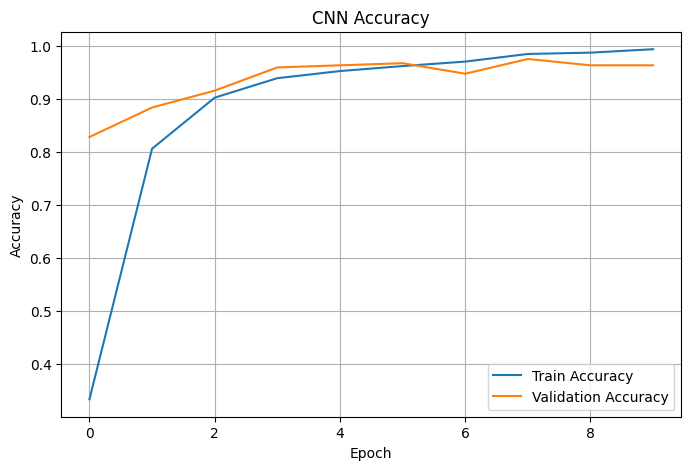

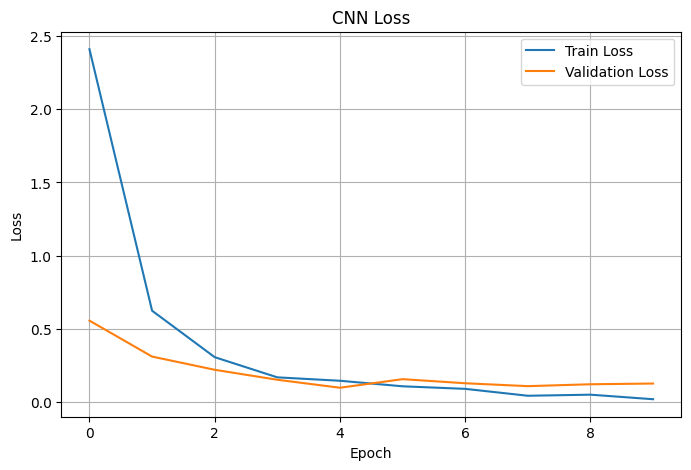

In [14]:
plt.figure(figsize=(8,5))
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

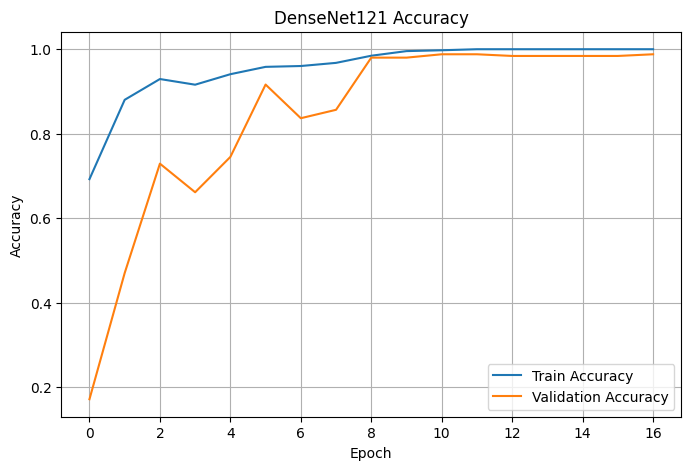

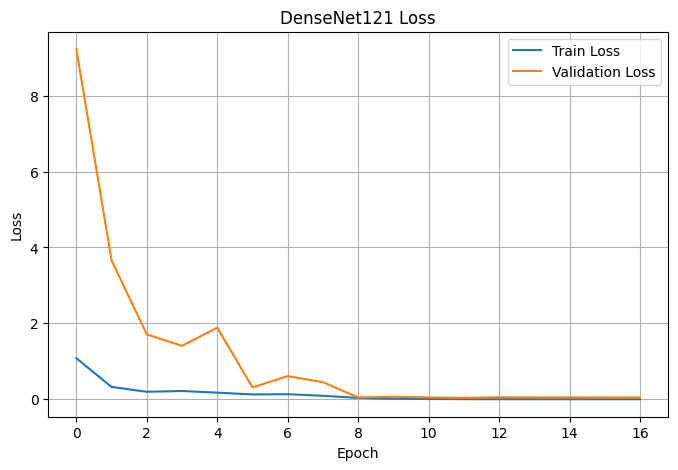

In [15]:
plt.figure(figsize=(8,5))
plt.plot(Den_history.history['accuracy'], label='Train Accuracy')
plt.plot(Den_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('DenseNet121 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(Den_history.history['loss'], label='Train Loss')
plt.plot(Den_history.history['val_loss'], label='Validation Loss')
plt.title('DenseNet121 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

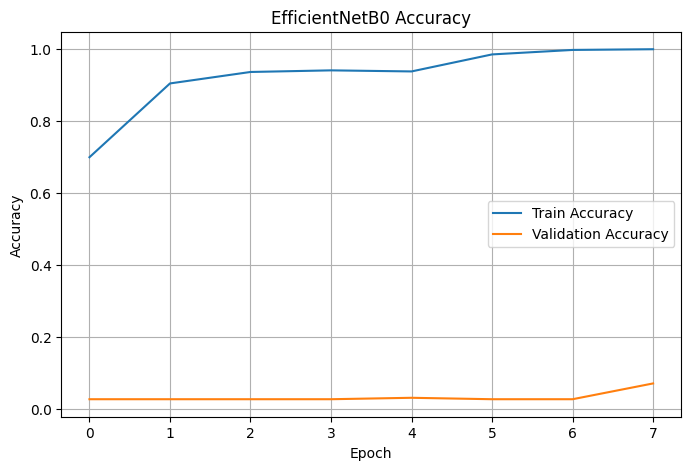

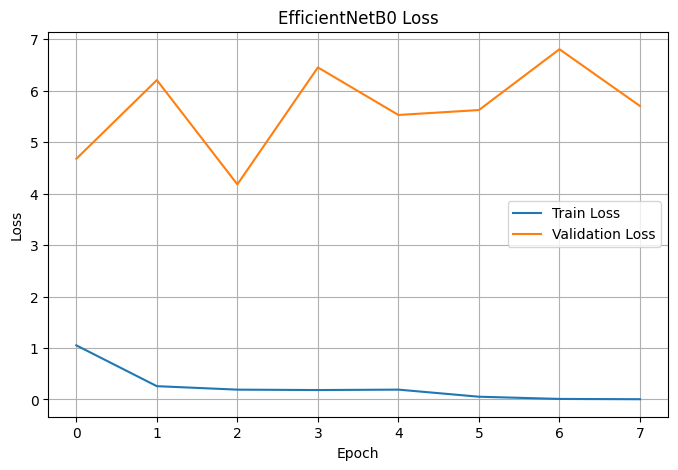

In [16]:
plt.figure(figsize=(8,5))
plt.plot(EffNet_history.history['accuracy'], label='Train Accuracy')
plt.plot(EffNet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB0 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(EffNet_history.history['loss'], label='Train Loss')
plt.plot(EffNet_history.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Evaluate CNN model
cnn_test_loss, cnn_test_accuracy = cnn.evaluate(test)
print(f"CNN Test Loss: {cnn_test_loss:.4f}")
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# Evaluate DenseNet model
den_test_loss, den_test_accuracy = Den.evaluate(test)
print(f"DenseNet Test Loss: {den_test_loss:.4f}")
print(f"DenseNet Test Accuracy: {den_test_accuracy:.4f}")

# Evaluate EfficientNet model
effnet_test_loss, effnet_test_accuracy = EffNet.evaluate(test)
print(f"EfficientNet Test Loss: {effnet_test_loss:.4f}")
print(f"EfficientNet Test Accuracy: {effnet_test_accuracy:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.9554 - loss: 0.2220
CNN Test Loss: 0.2915
CNN Test Accuracy: 0.9405
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 948ms/step - accuracy: 0.9827 - loss: 0.0433
DenseNet Test Loss: 0.0728
DenseNet Test Accuracy: 0.9683
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step - accuracy: 0.0588 - loss: 4.0883
EfficientNet Test Loss: 4.1796
EfficientNet Test Accuracy: 0.0278


In [18]:
Den.save('asl_model_Den.h5')

In [19]:
from tensorflow.keras.models import load_model
loaded_model_Den = load_model('asl_model_Den.h5')

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       0.88      1.00      0.93         7
           2       0.88      1.00      0.93         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      0.86      0.92         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
           a       1.00      1.00      1.00         7
           b       1.00      1.00      1.00         7
           c       1.00      1.00      1.00         7
           d       1.00      1.00      1.00         7
           e       1.00      1.00      1.00         7
           f       1.00      1.00      1.00         7
           g       1.00      1.00      1.00 

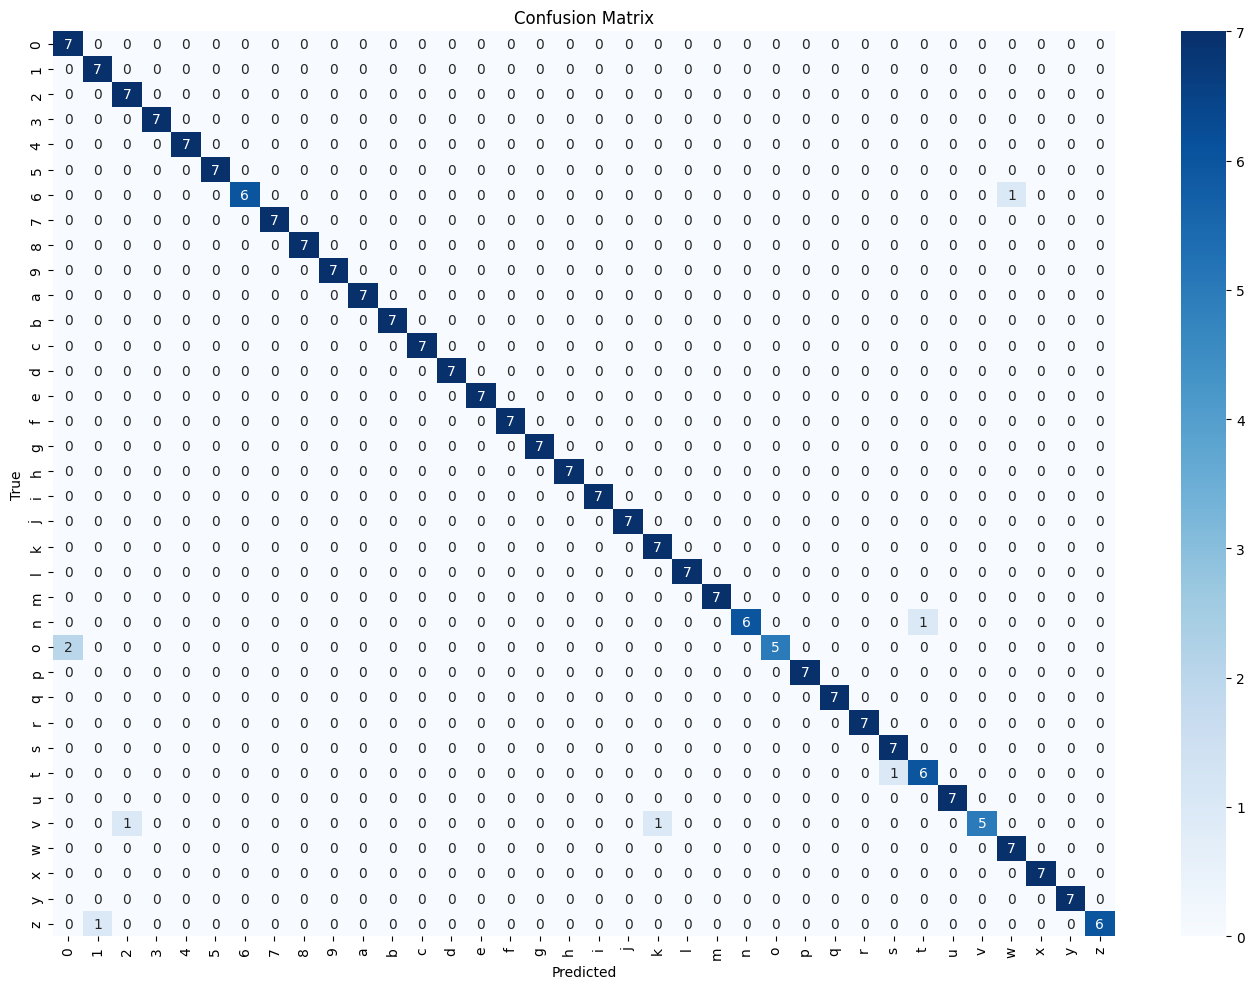

In [20]:
import seaborn as sns

y_true = test.classes
y_pred_probs = loaded_model_Den.predict(test)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()